In [1]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models.resnet import BasicBlock
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from PIL import Image
import pandas as pd
import os

In [3]:
class SteelDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                str(self.data.iloc[idx, 1]),
                                self.data.iloc[idx, 0])
        image = Image.open(img_name)
        # 이미지를 6등분하여 각각 (224, 224)로 리사이즈
        img_parts = []
        width, height = image.size
        crop_size = (width // 3, height // 2)
        for i in range(2):
            for j in range(3):
                left = j * crop_size[0]
                upper = i * crop_size[1]
                right = left + crop_size[0]
                lower = upper + crop_size[1]
                img_part = image.crop((left,
                                       upper,
                                       right,
                                       lower,
                                       )).resize((224, 224))
                img_parts.append(img_part)

        label = int(self.data.iloc[idx, 1]) - 1  # 라벨을 0부터 시작하도록 변환
        if self.transform:
            img_parts = [self.transform(part) for part in img_parts]
        return img_parts, label

In [14]:
# 하이퍼파라미터 설정
batch_size = 32
learning_rate = 0.001
num_classes = 4

# 데이터 로드 및 전처리
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = SteelDataset(csv_path='/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/aug-train.csv',
                              img_dir='/content/drive/MyDrive/졸업과제/working/aug_train/',
                              transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
class ResNetSteelClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetSteelClassifier, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetSteelClassifier(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as t:
        for img_parts, labels in t:
            optimizer.zero_grad()
            outputs = []

            for part in img_parts:
                # images, labels = images.to(device), labels.to(device)
                part = part.to(device)
                part_outputs = model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)  # 이미지 부분의 출력 평균
            labels = labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            t.set_postfix(loss=running_loss / (t.n + 1))

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 학습된 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/졸업과제/모델/resnet_model_V1_epoch_10.pth')

In [5]:
# 모델 불러오기
loaded_model = ResNetSteelClassifier(num_classes=4).to(device)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/졸업과제/모델/resnet_model_V1_epoch_10.pth'))
loaded_model.eval()

ResNetSteelClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
# 모델 평가
preds = []
targets = []

with torch.no_grad(), tqdm(train_loader, unit="batch") as t:
    for img_parts, labels in t:

        optimizer.zero_grad()
        outputs = []

        for part in img_parts:
            # images, labels = images.to(device), labels.to(device)
            part = part.to(device)
            part_outputs = loaded_model(part)
            part_outputs = part_outputs.to(device)
            outputs.append(part_outputs)

        outputs = torch.stack(outputs, dim=1).mean(dim=1)
        _, predicted = torch.max(outputs, 1)
        targets.extend(labels.cpu().numpy())
        preds.extend(predicted.cpu().numpy())
        t.set_postfix(accuracy=accuracy_score(targets, preds))

# 평가 지표 계산
accuracy = accuracy_score(targets, preds)
precision = precision_score(targets, preds, average='weighted')
recall = recall_score(targets, preds, average='weighted')
f1 = f1_score(targets, preds, average='weighted')

print()
print("Train")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

100%|██████████| 125/125 [29:16<00:00, 14.05s/batch, accuracy=0.779]


Train
Accuracy: 0.7790
Precision: 0.7843
Recall: 0.7790
F1 Score: 0.7755


In [9]:
# 테스트 데이터 로드 및 전처리
test_dataset = SteelDataset(csv_path='/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/aug-test.csv',
                              img_dir='/content/drive/MyDrive/졸업과제/working/aug-test/',
                              transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

# 모델 평가 및 평가 지표 계산 (테스트 데이터)
test_preds = []
test_targets = []

with torch.no_grad(), tqdm(test_loader, unit="batch") as t:
    for img_parts, labels in t:


        outputs = []

        for part in img_parts:
            # images, labels = images.to(device), labels.to(device)
            part = part.to(device)
            part_outputs = loaded_model(part)
            part_outputs = part_outputs.to(device)
            outputs.append(part_outputs)

        outputs = torch.stack(outputs, dim=1).mean(dim=1)
        _, predicted = torch.max(outputs, 1)
        test_targets.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
        t.set_postfix(test_accuracy=accuracy_score(test_targets, test_preds))

# 평가 지표 계산 (테스트 데이터)
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='weighted')
test_recall = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')

print()
print("Test")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

100%|██████████| 32/32 [13:56<00:00, 26.14s/batch, test_accuracy=0.744]


Test
Accuracy: 0.7440
Precision: 0.7499
Recall: 0.7440
F1 Score: 0.7389


In [11]:
test_dataset = SteelDataset(csv_path='/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/aug-test.csv',
                              img_dir='/content/drive/MyDrive/졸업과제/working/aug-test/',
                              transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [ ]:
num_epochs = 20
epoch_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# 에포크별 평가
for epoch in range(num_epochs):
    loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/졸업과제/모델/resnet_model_V1_epoch_10.pth'))
    loaded_model.eval()

    # correct = 0
    # total = 0

    test_preds = []
    test_targets = []

    with torch.no_grad(), tqdm(test_loader, unit="batch") as t:
        for img_parts, labels in t:
            outputs = []

            for part in img_parts:
                # images, labels = images.to(device), labels.to(device)
                part = part.to(device)
                part_outputs = loaded_model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)
            _, predicted = torch.max(outputs, 1)
            test_targets.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            t.set_postfix(test_accuracy=accuracy_score(test_targets, test_preds))


        accuracy = accuracy_score(test_targets, test_preds)
        precision = precision_score(test_targets, test_preds, average='weighted')
        recall = recall_score(test_targets, test_preds, average='weighted')
        f1 = f1_score(test_targets, test_preds, average='weighted')

        epoch_list.append(epoch + 1)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        print('-' * 20)


In [ ]:
import matplotlib.pyplot as plt
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, accuracy_list, label='Accuracy')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, f1_list, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Performance Metrics by Epoch')
plt.legend()
plt.grid()
plt.show()

### 에포크마다 train, test 성능 평가

In [18]:
num_epochs = 15

train_epoch_list = []
train_accuracy_list = []
train_precision_list = []
train_recall_list = []
train_f1_list = []
train_loss = []

test_epoch_list = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as t:
        for img_parts, labels in t:
            optimizer.zero_grad()
            outputs = []

            for part in img_parts:
                # images, labels = images.to(device), labels.to(device)
                part = part.to(device)
                part_outputs = model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)  # 이미지 부분의 출력 평균
            labels = labels.to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            t.set_postfix(loss=running_loss / (t.n + 1))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_loss.append(loss.item())

    train_preds = []
    train_targets = []

    with torch.no_grad(), tqdm(train_loader, unit="batch") as t:
        for img_parts, labels in t:
            outputs = []

            for part in img_parts:
                part = part.to(device)
                part_outputs = loaded_model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)
            _, predicted = torch.max(outputs, 1)
            train_targets.extend(labels.cpu().numpy())
            train_preds.extend(predicted.cpu().numpy())

            t.set_postfix(accuracy=accuracy_score(train_targets, train_preds))


        train_accuracy = accuracy_score(train_targets, train_preds)
        train_precision = precision_score(train_targets, train_preds, average='weighted')
        train_recall = recall_score(train_targets, train_preds, average='weighted')
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        train_epoch_list.append(epoch + 1)
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}')
        print('-' * 20)

    with torch.no_grad(), tqdm(test_loader, unit="batch") as t:
        for img_parts, labels in t:
            outputs = []

            for part in img_parts:
                part = part.to(device)
                part_outputs = loaded_model(part)
                part_outputs = part_outputs.to(device)
                outputs.append(part_outputs)

            outputs = torch.stack(outputs, dim=1).mean(dim=1)
            _, predicted = torch.max(outputs, 1)
            test_targets.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())
            t.set_postfix(test_accuracy=accuracy_score(test_targets, test_preds))


        test_accuracy = accuracy_score(test_targets, test_preds)
        test_precision = precision_score(test_targets, test_preds, average='weighted')
        test_recall = recall_score(test_targets, test_preds, average='weighted')
        test_f1 = f1_score(test_targets, test_preds, average='weighted')

        test_epoch_list.append(epoch + 1)
        test_accuracy_list.append(test_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
        print('-' * 20)

100%|██████████| 125/125 [32:06<00:00, 15.41s/batch, loss=1.06]


Epoch [1/15], Loss: 0.8696


100%|██████████| 125/125 [02:02<00:00,  1.02batch/s, accuracy=0.775]


Epoch [1/15]
Accuracy: 0.7748, Precision: 0.7800, Recall: 0.7748, F1: 0.7714
--------------------


100%|██████████| 32/32 [00:30<00:00,  1.04batch/s, test_accuracy=0.756]


Epoch [1/15]
Accuracy: 0.7560, Precision: 0.7608, Recall: 0.7560, F1: 0.7531
--------------------


100%|██████████| 125/125 [02:51<00:00,  1.37s/batch, loss=0.954]


Epoch [2/15], Loss: 1.1177


100%|██████████| 125/125 [02:03<00:00,  1.02batch/s, accuracy=0.777]


Epoch [2/15]
Accuracy: 0.7768, Precision: 0.7829, Recall: 0.7768, F1: 0.7735
--------------------


100%|██████████| 32/32 [00:30<00:00,  1.04batch/s, test_accuracy=0.755]


Epoch [2/15]
Accuracy: 0.7551, Precision: 0.7614, Recall: 0.7551, F1: 0.7516
--------------------


100%|██████████| 125/125 [02:50<00:00,  1.36s/batch, loss=0.845]


Epoch [3/15], Loss: 0.9856


100%|██████████| 125/125 [02:01<00:00,  1.03batch/s, accuracy=0.784]


Epoch [3/15]
Accuracy: 0.7840, Precision: 0.7914, Recall: 0.7840, F1: 0.7806
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.08batch/s, test_accuracy=0.754]


Epoch [3/15]
Accuracy: 0.7541, Precision: 0.7599, Recall: 0.7541, F1: 0.7501
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.827]


Epoch [4/15], Loss: 1.3278


100%|██████████| 125/125 [01:59<00:00,  1.05batch/s, accuracy=0.782]


Epoch [4/15]
Accuracy: 0.7817, Precision: 0.7884, Recall: 0.7817, F1: 0.7785
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.09batch/s, test_accuracy=0.751]


Epoch [4/15]
Accuracy: 0.7514, Precision: 0.7588, Recall: 0.7514, F1: 0.7477
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.791]


Epoch [5/15], Loss: 0.7215


100%|██████████| 125/125 [02:00<00:00,  1.04batch/s, accuracy=0.781]


Epoch [5/15]
Accuracy: 0.7810, Precision: 0.7865, Recall: 0.7810, F1: 0.7772
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.07batch/s, test_accuracy=0.749]


Epoch [5/15]
Accuracy: 0.7486, Precision: 0.7551, Recall: 0.7486, F1: 0.7447
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.763]


Epoch [6/15], Loss: 0.9169


100%|██████████| 125/125 [02:00<00:00,  1.04batch/s, accuracy=0.776]


Epoch [6/15]
Accuracy: 0.7762, Precision: 0.7819, Recall: 0.7762, F1: 0.7730
--------------------


100%|██████████| 32/32 [00:30<00:00,  1.07batch/s, test_accuracy=0.75]


Epoch [6/15]
Accuracy: 0.7495, Precision: 0.7560, Recall: 0.7495, F1: 0.7455
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.72]


Epoch [7/15], Loss: 0.6164


100%|██████████| 125/125 [01:57<00:00,  1.07batch/s, accuracy=0.78]


Epoch [7/15]
Accuracy: 0.7805, Precision: 0.7858, Recall: 0.7805, F1: 0.7774
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.07batch/s, test_accuracy=0.75]


Epoch [7/15]
Accuracy: 0.7503, Precision: 0.7562, Recall: 0.7503, F1: 0.7463
--------------------


100%|██████████| 125/125 [02:46<00:00,  1.33s/batch, loss=0.719]


Epoch [8/15], Loss: 0.6442


100%|██████████| 125/125 [02:01<00:00,  1.02batch/s, accuracy=0.781]


Epoch [8/15]
Accuracy: 0.7815, Precision: 0.7876, Recall: 0.7815, F1: 0.7777
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.08batch/s, test_accuracy=0.748]


Epoch [8/15]
Accuracy: 0.7484, Precision: 0.7544, Recall: 0.7484, F1: 0.7443
--------------------


100%|██████████| 125/125 [02:46<00:00,  1.33s/batch, loss=0.698]


Epoch [9/15], Loss: 0.5580


100%|██████████| 125/125 [02:01<00:00,  1.03batch/s, accuracy=0.779]


Epoch [9/15]
Accuracy: 0.7795, Precision: 0.7850, Recall: 0.7795, F1: 0.7758
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.09batch/s, test_accuracy=0.748]


Epoch [9/15]
Accuracy: 0.7483, Precision: 0.7542, Recall: 0.7483, F1: 0.7442
--------------------


100%|██████████| 125/125 [02:46<00:00,  1.34s/batch, loss=0.692]


Epoch [10/15], Loss: 1.0025


100%|██████████| 125/125 [02:00<00:00,  1.04batch/s, accuracy=0.779]


Epoch [10/15]
Accuracy: 0.7790, Precision: 0.7846, Recall: 0.7790, F1: 0.7755
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.07batch/s, test_accuracy=0.748]


Epoch [10/15]
Accuracy: 0.7477, Precision: 0.7537, Recall: 0.7477, F1: 0.7437
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.65]


Epoch [11/15], Loss: 0.4988


100%|██████████| 125/125 [01:58<00:00,  1.06batch/s, accuracy=0.778]


Epoch [11/15]
Accuracy: 0.7782, Precision: 0.7840, Recall: 0.7782, F1: 0.7749
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.09batch/s, test_accuracy=0.747]


Epoch [11/15]
Accuracy: 0.7472, Precision: 0.7533, Recall: 0.7472, F1: 0.7431
--------------------


100%|██████████| 125/125 [02:50<00:00,  1.36s/batch, loss=0.664]


Epoch [12/15], Loss: 0.2965


100%|██████████| 125/125 [02:00<00:00,  1.03batch/s, accuracy=0.778]


Epoch [12/15]
Accuracy: 0.7780, Precision: 0.7822, Recall: 0.7780, F1: 0.7742
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.09batch/s, test_accuracy=0.747]


Epoch [12/15]
Accuracy: 0.7465, Precision: 0.7528, Recall: 0.7465, F1: 0.7424
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.646]


Epoch [13/15], Loss: 0.3969


100%|██████████| 125/125 [01:59<00:00,  1.04batch/s, accuracy=0.779]


Epoch [13/15]
Accuracy: 0.7792, Precision: 0.7860, Recall: 0.7792, F1: 0.7756
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.09batch/s, test_accuracy=0.746]


Epoch [13/15]
Accuracy: 0.7464, Precision: 0.7526, Recall: 0.7464, F1: 0.7423
--------------------


100%|██████████| 125/125 [02:47<00:00,  1.34s/batch, loss=0.626]


Epoch [14/15], Loss: 0.5261


100%|██████████| 125/125 [01:57<00:00,  1.06batch/s, accuracy=0.781]


Epoch [14/15]
Accuracy: 0.7812, Precision: 0.7866, Recall: 0.7812, F1: 0.7775
--------------------


100%|██████████| 32/32 [00:29<00:00,  1.09batch/s, test_accuracy=0.746]


Epoch [14/15]
Accuracy: 0.7458, Precision: 0.7518, Recall: 0.7458, F1: 0.7417
--------------------


 45%|████▍     | 56/125 [01:16<01:33,  1.36s/batch, loss=0.606]


KeyboardInterrupt: ignored

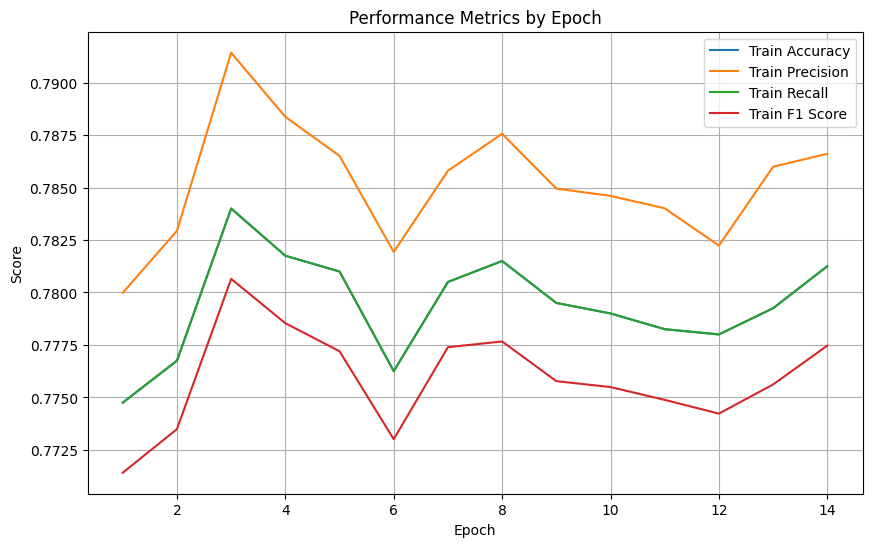

In [20]:
import matplotlib.pyplot as plt
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epoch_list[:14], train_accuracy_list[:14], label='Train Accuracy')
plt.plot(epoch_list[:14], train_precision_list[:14], label='Train Precision')
plt.plot(epoch_list[:14], train_recall_list[:14], label='Train Recall')
plt.plot(epoch_list[:14], train_f1_list[:14], label='Train F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Performance Metrics by Epoch')
plt.legend()
plt.grid()
plt.show()

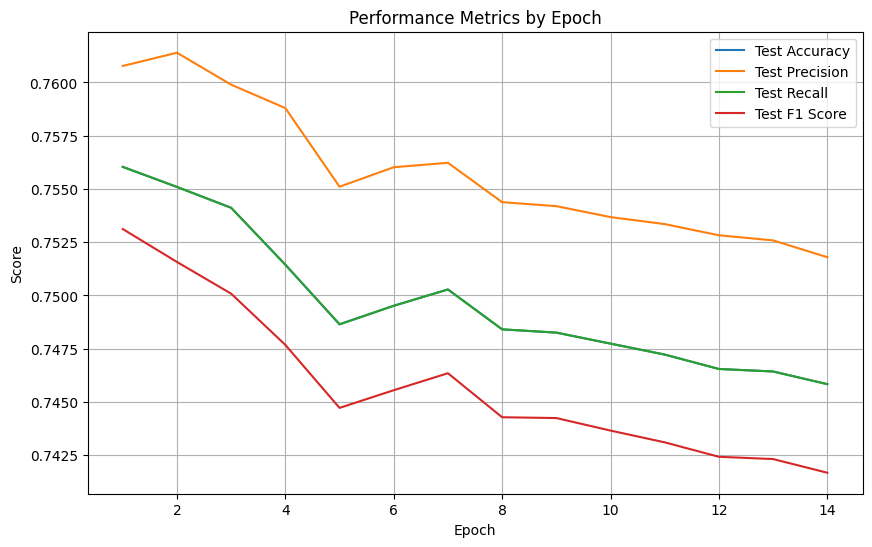

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_list[:14], test_accuracy_list[:14], label='Test Accuracy')
plt.plot(epoch_list[:14], test_precision_list[:14], label='Test Precision')
plt.plot(epoch_list[:14], test_recall_list[:14], label='Test Recall')
plt.plot(epoch_list[:14], test_f1_list[:14], label='Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Performance Metrics by Epoch')
plt.legend()
plt.grid()
plt.show()

### 직접 구현된 코드

In [ ]:
# ResNet 모델 정의
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ResNet 모델 인스턴스 생성 및 GPU로 이동
model = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished!")